# correlation heatmap

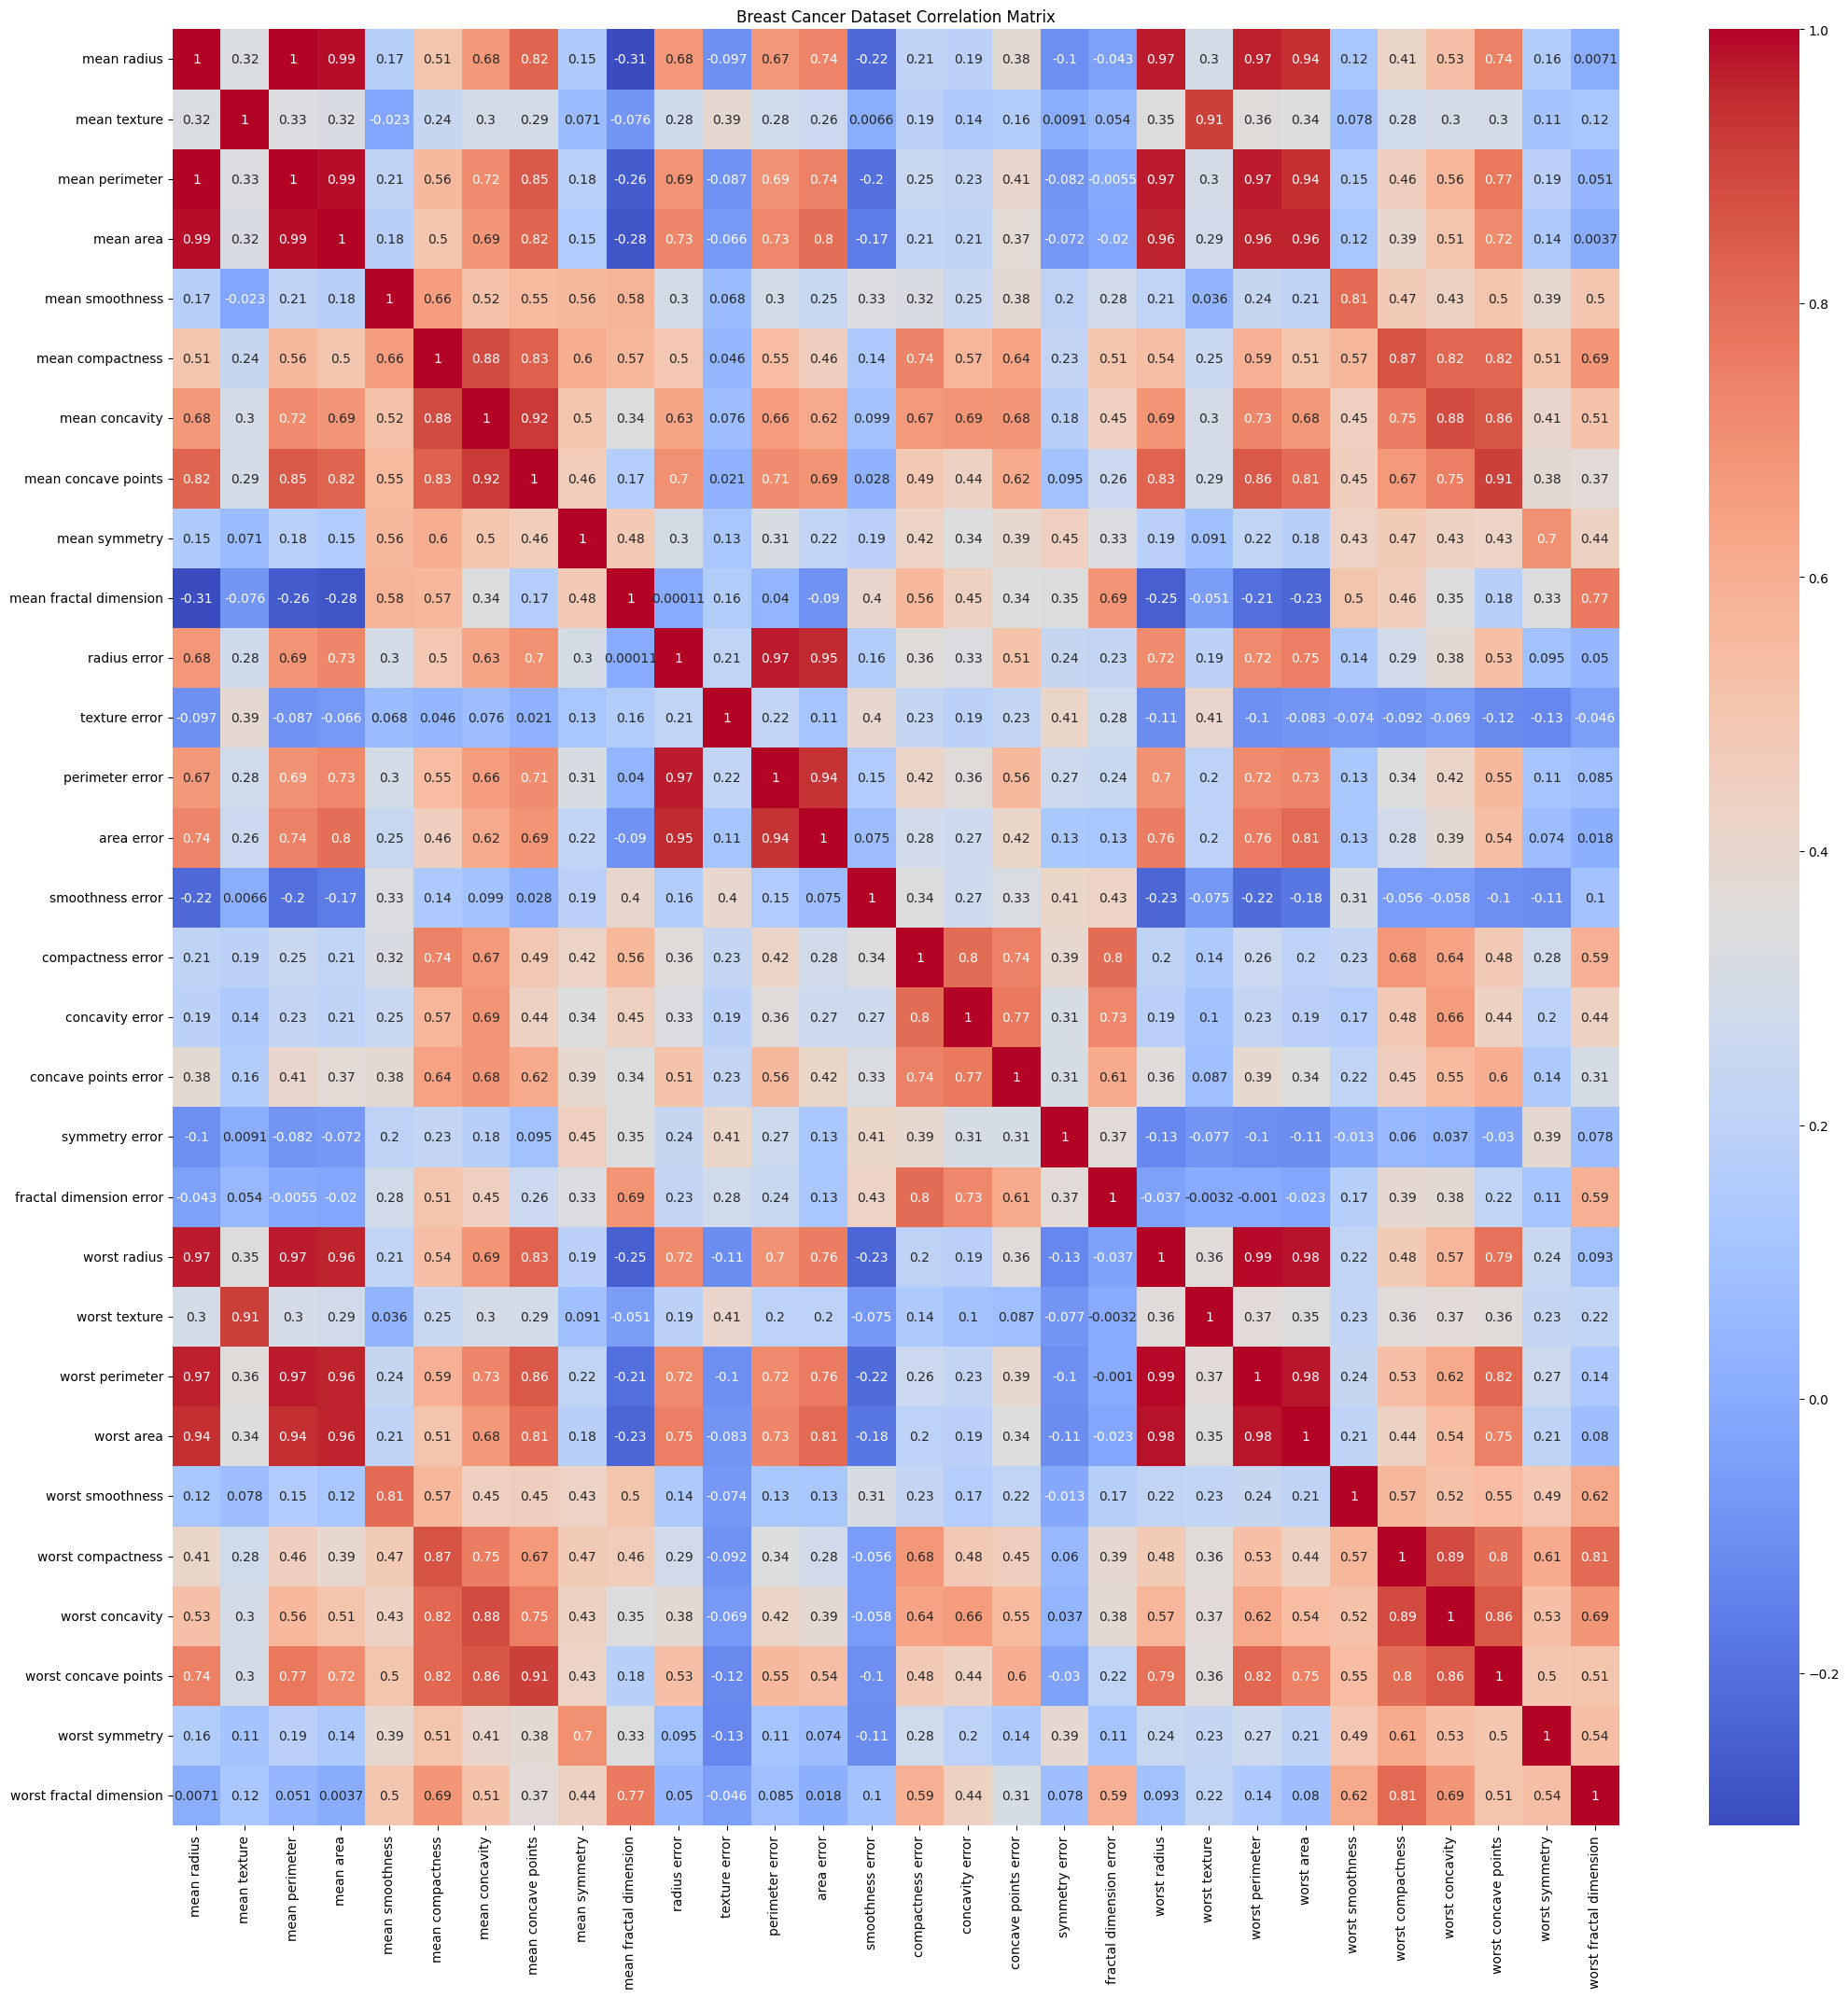

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)

corr_matrix = df.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Breast Cancer Dataset Correlation Matrix')
plt.show()

# Desicion Tree


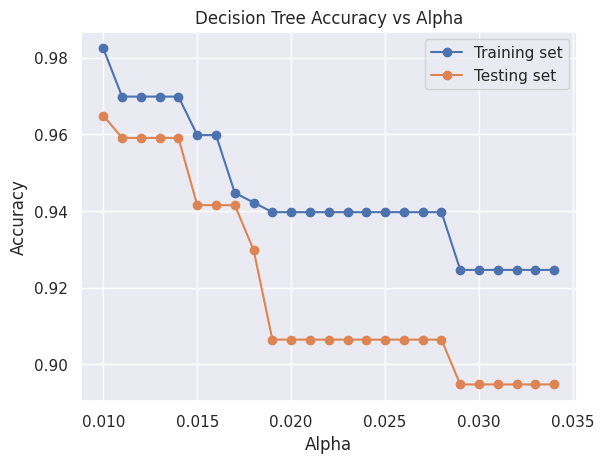

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

alphas = np.arange(0.01, 0.035, 0.001)

train_accuracies = []
test_accuracies = []

for alpha in alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

sns.set()
plt.plot(alphas, train_accuracies, marker="o", label='Training set')
plt.plot(alphas, test_accuracies, marker="o", label='Testing set')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Alpha')
plt.legend()
plt.show()


# Random Forest

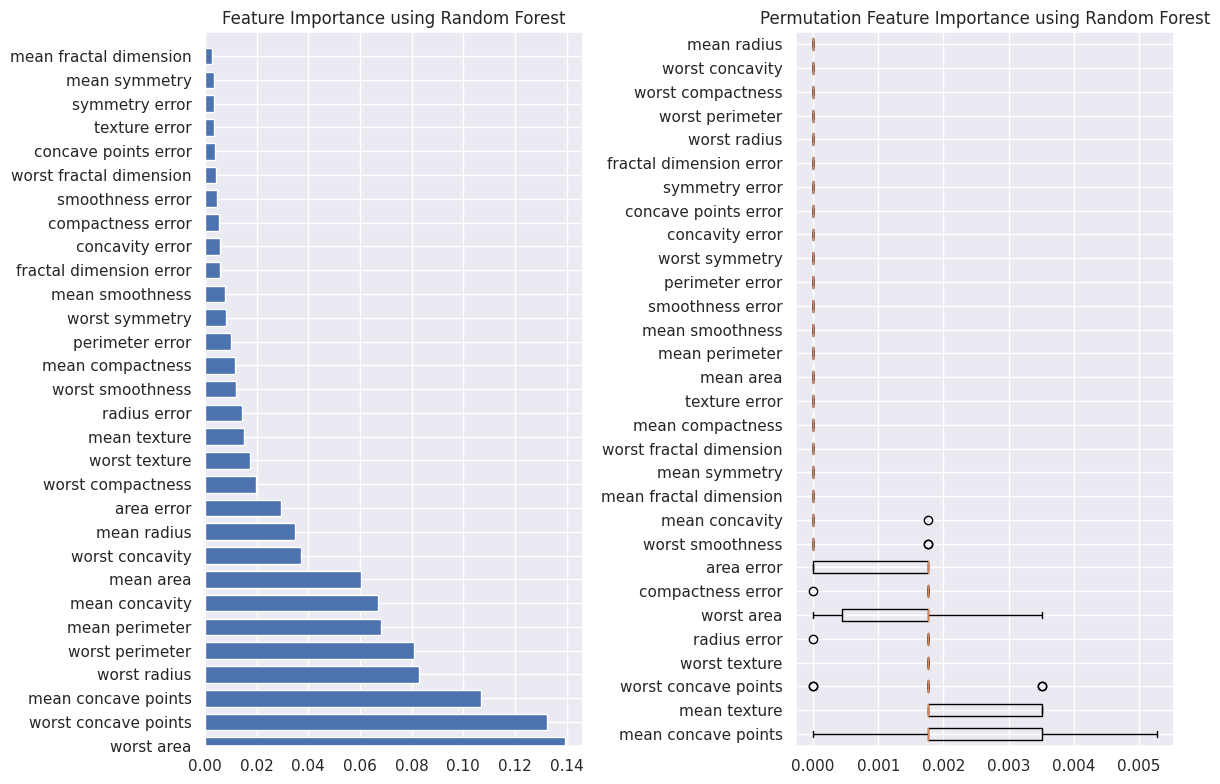

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

data = load_breast_cancer()
X, y = data.data, data.target

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

tree_importance_sorted_idx = clf.feature_importances_.argsort()[::-1]
tree_indices = range(len(clf.feature_importances_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.set_title("Feature Importance using Random Forest")

result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()[::-1]

ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
ax2.set_title("Permutation Feature Importance using Random Forest")
fig.tight_layout()

plt.show()

# Self-Training

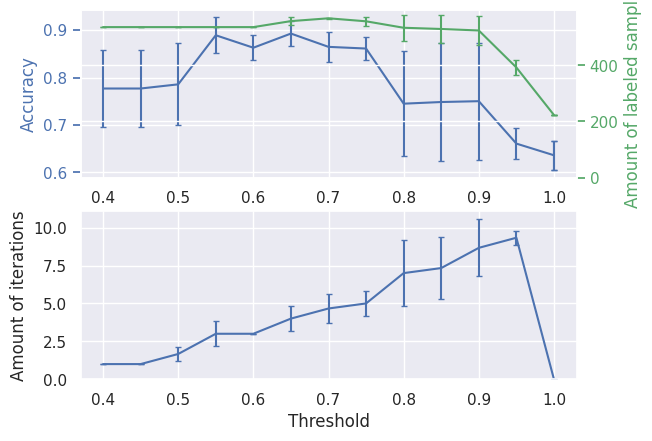

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()